## ARCH Model Forecasting

**Functions**

`sm.OLS`, `sm.WLS`


### Exercise 77

Use 50% of the sample to estimate your preferred GARCH model for returns to the S&P 500 and the
EUR/USD rate, and construct forecasts for the remaining period.

In [1]:
%matplotlib inline

In [2]:
from arch import arch_model
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import numpy as np
register_matplotlib_converters()

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)

#### Explanation

These are standard imports and commands to configure matplotlib.  The command
is needed when plotting pandas Series and DataFrames that have 
date indices.

In [3]:
sp500 = pd.read_hdf('./data/arch-data.h5','sp500')
# Get the series
sp500 = sp500.SP500
returns = 1000 * sp500.pct_change().dropna()
# TARCH(1,1,1)
mod = arch_model(returns, o=1, power=1.0)
last = returns.index[returns.shape[0] // 2]
res = mod.fit(last_obs=last, disp="off")
in_samp_variance = res.conditional_volatility ** 2
# Look at the last 5 observations that have volatilities
print(last)
in_samp_variance.dropna().tail()

2015-01-07 00:00:00


DATE
2014-12-30     44.273922
2014-12-31     54.255580
2015-01-02     83.900727
2015-01-05     73.360884
2015-01-06    142.303282
Name: cond_vol, dtype: float64

In [4]:
forecasts = res.forecast(align="target")
oos_variance = forecasts.variance.dropna()
oos_variance

,h.1
DATE,
2015-01-07,164.597056
2015-01-08,135.068837
2015-01-09,111.715525
2015-01-12,133.144959
2015-01-13,151.692921
...,...
2019-12-24,20.407730
2019-12-26,20.146119
2019-12-27,18.951014


#### Explanation

This cell starts by importing the data and creating returns using a scale of
1000. The TARCH(1,1,1) model is constructed using `arch_model` and
then estimated by setting `last_obs` which sets the final observation
used in the fit. Note that `last_obs` is not actually used in fitting,
and only dates < `last_obs` are.

The forecasts are computed using `forecast` with `align` set to
"target". This simplifies evaluating forecasts since the forecast
is already aligned with the evaluation sample. 

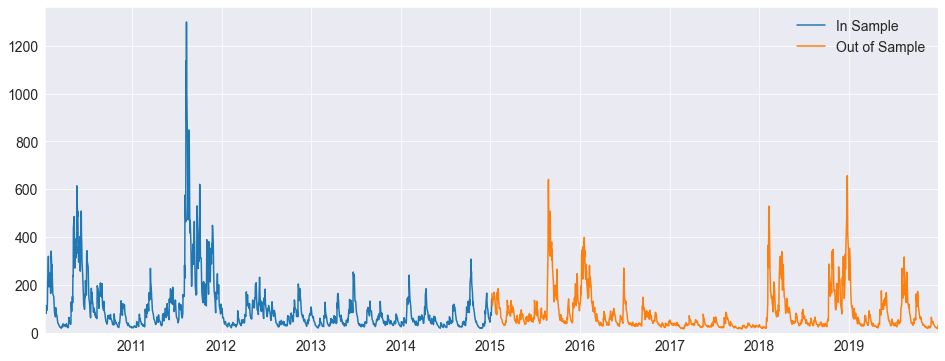

In [5]:
fig, ax = plt.subplots(1, 1)
plt.plot(in_samp_variance, label="In Sample")
plt.plot(oos_variance, label="Out of Sample")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ylim = ax.set_ylim(0, ax.get_ylim()[1])
# The _ is used to capture the output from the legend command so that
# does not print
_ = plt.legend(frameon=False)

#### Explanation

Here we plot the fitted and foreast variance.
 

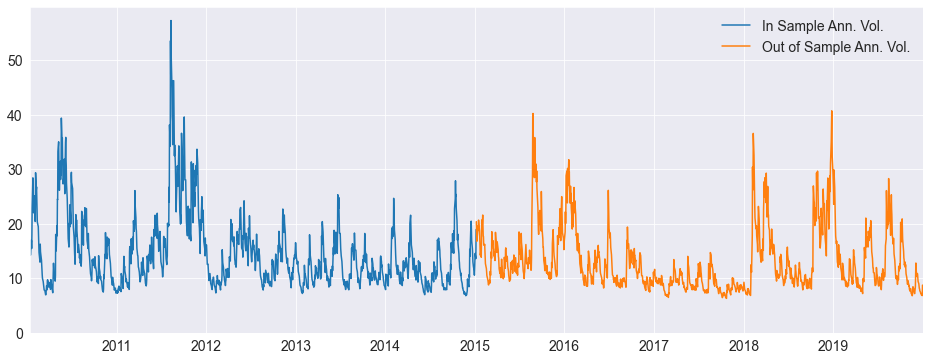

In [6]:
_, ax = plt.subplots(1, 1)
plt.plot(np.sqrt(252*in_samp_variance / 100), label="In Sample Ann. Vol.")
plt.plot(np.sqrt(252*oos_variance / 100), label="Out of Sample Ann. Vol.")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

#### Explanation

We can also plot the volaitlity.  Note that the variance is divided by 100 so that
it is the annualized percentage vol. This is identical what would  happen if returns
had been initially scaled by 100 rather than 1000. 

### Exercise 78

Evaluate the accuracy of the forecasts.

In [7]:
# Join the returns and the variance forecasts
combined = pd.concat([returns, oos_variance], axis = 1)
combined.columns = ["returns","oos_variance"]
# Remove mossing
combined = combined.dropna() 

#### Explanation

We start by by joining the forecast variance with the returns. 
Dropping missing is a simple method to remove observations without
a forecast. 

In [8]:
import statsmodels.api as sm

# Construct the error
mu = res.params["mu"]
variance_error = (combined.returns - mu) ** 2 - combined.oos_variance
x = sm.add_constant(combined.oos_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03104
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.860
Time:                        17:37:08   Log-Likelihood:                -8095.5
No. Observations:                1255   AIC:                         1.619e+04
Df Residuals:                    1253   BIC:                         1.621e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.2936     11.385     -0.641      0.522     -29.608      15.020
oos_variance    -0.0296      0.168     -0.176      0.860      -0.359       0.300
==============================================================================
Omnibus:                     1316.028   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93722.038
Skew:                           5.001   Prob(JB):                         0.00
Kurtosis:                      44.137   Cond. No.                         162.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### Explanation

We use a Mincer-Zarnowitz regression of the forecast error, which is defined

$$ \left(r_{t+1}-\hat{\mu}\right)^2 - \hat{\sigma}^2_{t+1},$$

on a constant and the forecast variance. We set `cov_type` to "HC0" to get
White's covariance estimator.  

In [9]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")


Stat: 7.584749843393846, Pval:0.022542002738071568


#### Explanation

A Wald test of the null $H_0:\alpha=\beta=0$ is used to jointly
test the parameters.

In [10]:
res = sm.WLS(variance_error, x, weights=1./(combined.oos_variance**2)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2804
Date:                Tue, 15 Dec 2020   Prob (F-statistic):              0.597
Time:                        17:37:08   Log-Likelihood:                -7637.6
No. Observations:                1255   AIC:                         1.528e+04
Df Residuals:                    1253   BIC:                         1.529e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.1783      3.976     -1.303      0.193     -12.978       2.621
oos_variance    -0.0526      0.099     -0.530      0.597      -0.248       0.142
==============================================================================
Omnibus:                     1831.139   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           638127.043
Skew:                           8.357   Prob(JB):                         0.00
Kurtosis:                     112.196   Cond. No.                         77.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use a weighted LS estimator where the variance is the inverse
of the squared forecast.  The creates the MZ-GLS test.


In [11]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

Stat: 11.92656389463991, Pval:0.002571458716002968


#### Explanation

The Wald test is the same only using the WLS result.


### Exercise 79

Evaluate the accuracy of forecasts from a 2-year backward moving average variance.

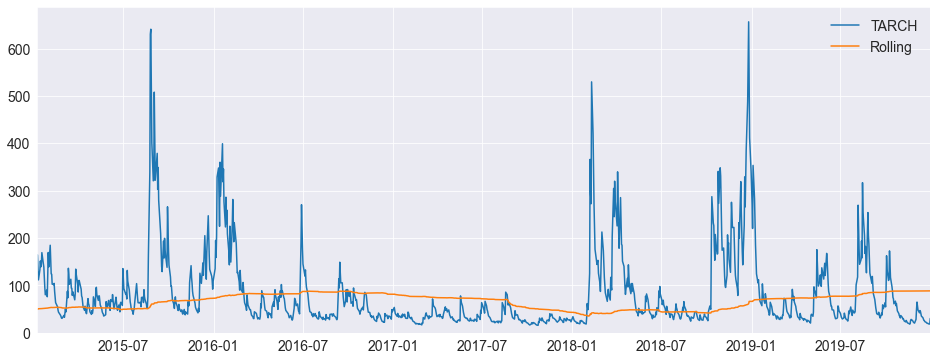

In [12]:
rolling_variance = (returns**2).rolling(2*252).mean()
rolling_variance = rolling_variance.shift(1)
rolling_variance.name = "rolling_variance"
rolling_mean = returns.rolling(2*252).mean()
rolling_mean = rolling_mean.shift(1)
rolling_mean.name = "rolling_mean"
combined = pd.concat([combined, rolling_mean, rolling_variance], axis=1).dropna()

_, ax = plt.subplots(1, 1)
plt.plot(combined.oos_variance, label="TARCH")
plt.plot(combined.rolling_variance, label="Rolling")
ax.set_xlim(combined.index[0], combined.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

#### Explanation

Next, we can use `rolling` to estimate the mean and the variance. The rolling
mean is used when computing the out-of-sample residual which is used in model
evaluation.

In [13]:
# Construct the error
eps = combined.returns - combined.rolling_mean
variance_error = eps ** 2 - combined.rolling_variance
x = sm.add_constant(combined.rolling_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     36.71
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           1.81e-09
Time:                        17:37:09   Log-Likelihood:                -8246.5
No. Observations:                1255   AIC:                         1.650e+04
Df Residuals:                    1253   BIC:                         1.651e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              135.4848     24.110      5.619      0.000      88.229     182.740
rolling_variance    -1.9623      0.324     -6.059      0.000      -2.597      -1.328
==============================================================================
Omnibus:                     1491.587   Durbin-Watson:                   1.459
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           154439.585
Skew:                           6.083   Prob(JB):                         0.00
Kurtosis:                      55.966   Cond. No.                         298.
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### Explanation
The shocks are the returns minus the mean. The variance error is then the
squared shock minus the variance. The MZ regression regresses the variance
error on a constant and the forecast. Both the constant and the forecast
have coefficients that are statstically different from zero.

In [14]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

Stat: 40.25728306645773, Pval:1.8123499239107088e-09


#### Explanation

The Wald test rejects badly. 

In [15]:
res = sm.WLS(variance_error, x, weights=1./(combined.rolling_variance**2)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.024
Model:                            WLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     31.31
Date:                Tue, 15 Dec 2020   Prob (F-statistic):           2.70e-08
Time:                        17:37:09   Log-Likelihood:                -8474.9
No. Observations:                1255   AIC:                         1.695e+04
Df Residuals:                    1253   BIC:                         1.696e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              138.6574     21.739      6.378      0.000      96.009     181.306
rolling_variance    -2.0136      0.360     -5.596      0.000      -2.720      -1.308
==============================================================================
Omnibus:                     1656.760   Durbin-Watson:                   1.446
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           282371.735
Skew:                           7.163   Prob(JB):                         0.00
Kurtosis:                      75.074   Cond. No.                         239.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Explanation
We can also use WLS here where the weights are the inverse of the squared forecast
to produce a MZ-GLS test.


In [16]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

Stat: 45.89503044070797, Pval:1.0814856628393317e-10


#### Explanation

Unsurprisingly a strong rejection here.

### Exercise 80

Compare the ARCH-model forecasts to a naive 2-year backward looking moving average using QLIKE.

In [17]:
#combined
forecasts = combined[["oos_variance","rolling_variance"]]
tarch_eps = combined.returns - mu
tarch_forecast = combined.oos_variance
qlik_tarch = (tarch_eps**2)/tarch_forecast + np.log(tarch_forecast)

rolling_eps = combined.returns - combined.rolling_mean
rolling_forecast = combined.rolling_variance
qlik_rolling = (rolling_eps**2)/rolling_forecast + np.log(rolling_forecast)

#### Explanation

The QLIK loss is defined as 

$$ \frac{\left(r_{t+1}-\hat{\mu}_{t+1}\right)}{\hat{\sigma}^2_{t+1}} + \ln{\hat{\sigma}^2_{t+1}}.$$

This value is computed for both forecast methods.

In [18]:
delta = qlik_tarch - qlik_rolling
lags = int(1.2 * delta.shape[0] ** (1/3))
dm = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags":lags})
dm.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 15 Dec 2020   Prob (F-statistic):                nan
Time:                        17:37:09   Log-Likelihood:                -2832.2
No. Observations:                1255   AIC:                             5666.
Df Residuals:                    1254   BIC:                             5672.
Df Model:                           0                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4637      0.094     -4.920      0.000      -0.648      -0.279
==============================================================================
Omnibus:                     1796.010   Durbin-Watson:                   1.650
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           598594.276
Skew:                          -8.052   Prob(JB):                         0.00
Kurtosis:                     108.773   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 12 lags and without small sample correction
"""

#### Explanation

The DM test is implemented as the difference between the losses. A Newey-West covariance
is required since we cannot beleive that both models are correctly specified.  Here I use
$1.2 \times T^{\frac{1}{3}}$ for simplicity. The statistic is computed by regressing
the difference on a constant and using a HAC covariance.